# Zero-shot classification of HEST-1k data

In [1]:
# # load '/mnt/c/src/hest' in sys
# %load_ext autoreload
# %autoreload 2

# import sys
# import os

# module_path = '/mnt/c/src/HEST/src'
# sys.path.insert(0, module_path)
# print(sys.path)

In [15]:
!uv pip install slideflow[torch] cucim cupy-cuda12x

Resolved 179 packages in 2.30s                                       
Prepared 115 packages in 4.88s                                           
░░░░░░░░░░░░░░░░░░░░ [0/122] Installing wheels...                               warning: Failed to hardlink files; falling back to full copy. This may lead to degraded performance.
         If the cache and target directories are on different filesystems, hardlinking may not be supported.
         If this is intentional, set `export UV_LINK_MODE=copy` or use `--link-mode=copy` to suppress this warning.
Installed 122 packages in 23.06s                            
 + absl-py==2.2.2
 + affine==2.4.0
 + aiohappyeyeballs==2.6.1
 + aiohttp==3.11.16
 + aiosignal==1.3.2
 + annotated-types==0.7.0
 + asciitree==0.3.3
 + async-timeout==5.0.1
 + attrs==25.3.0
 + beautifulsoup4==4.13.3
 + blis==0.7.11
 + catalogue==2.0.10
 + cellpose==2.1.1
 + cffi==1.17.1
 + click==8.1.8
 + click-plugins==1.1.1
 + cligj==0.7.2
 + cloudpathlib==0.21.0
 + cloudpickle==3.1.1


In [1]:
from conch.open_clip_custom import create_model_from_pretrained, tokenize, get_tokenizer
import torch
import os
from PIL import Image
from pathlib import Path

import h5py
import numpy as np
import pandas as pd
import seaborn as sns


/mnt/c/src/CONCH/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/c/src/CONCH/.venv/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
model_cfg = 'conch_ViT-B-16'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
checkpoint_path = './checkpoints/CONCH/pytorch_model.bin'
model, preprocess = create_model_from_pretrained(model_cfg, checkpoint_path, device=device)
_ = model.eval()

In [220]:
device

device(type='cuda', index=0)

In [227]:
# Exctract patches

datafolder = '/mnt/c/data/hest_data/patches/'
case = 'TENX95'

# read h5 file
with h5py.File(f'{datafolder}/{case}.h5', 'r') as h5_file:
    patches = h5_file['img']
    patches_np = np.asarray(patches)
    coords_np = np.asarray(h5_file['coords'])
    barcode_np = np.asarray(h5_file['barcode'])


In [228]:
len(patches_np)

7592

In [229]:
import json
metadata_path = '/mnt/c/data/hest_data/metadata/'

metadata = json.loads(open(f'{metadata_path}/{case}.json').read())

metadata['oncotree_code']

'IDC'

In [230]:
tokenizer = get_tokenizer()
classes = ['Breast Invasive Ductal Carcinoma (IDC)', 
           'Normal', 
           'Fat tissue']

idc_prompts = ['invasive ductal carcinoma',
                'breast invasive ductal carcinoma',
                'invasive ductal carcinoma of the breast',
                'invasive carcinoma of the breast, ductal pattern',
                'breast IDC']

normal_prompts = ['normal breast tissue',   
                  'non-tumor',
                  'normal breast parenchyma',
                  'normal breast stroma',
                  'breast stroma',
                  'breast parenchyma',
                  'normal tissue',
                  'normal breast tissue',
                  'non-cancerous tissue']

stroma_prompts = ['adipose tissue',
                    'adipose',
                    'adipose tissue in breast',
                    'breast adipose tissue',
                    'breast fat',
                    'fat',
                    'breast fat tissue',
                    'fat in breast',
                    'fat in breast tissue',
                    'fat in breast parenchyma',
                    'fat in breast stroma',
                    'breast fat parenchyma',]


# prompts = ['a zoomed in H&E image of invasive ductal carcinoma', 
#            'a zoomed in H&E image of normal breast tissue',
#            'a zoomed in H&E image of fat tissue']

prompts = ['CLASSNAME', 
        #    'a photomicrograph showing CLASSNAME',
        #    'a photomicrograph of CLASSNAME',
         #   'an image of CLASSNAME',
        #    'an image showing CLASSNAME',
        #    'an example of CLASSNAME',
        #    'CLASSNAME is shown',
         #   'there is CLASSNAME',
           'a histopathological image of CLASSNAME',
           'a histopathological photograph of CLASSNAME',
         #   'shows CLASSNAME',
           'presence of CLASSNAME',
           'CLASSNAME is present',
           'an H&E stained image of CLASSNAME',
        #    'an H&E stained image showing CLASSNAME',
        #    'an H&E image showing CLASSNAME',
          #  'an H&E image of CLASSNAME',
           'CLASSNAME, H&E stain',
           'CLASSNAME, H&E']

all_tissue_prompts = idc_prompts + normal_prompts + stroma_prompts
prompts_all = [a.replace('CLASSNAME', c) for c in all_tissue_prompts for a in prompts]
prompts_all

['invasive ductal carcinoma',
 'a histopathological image of invasive ductal carcinoma',
 'a histopathological photograph of invasive ductal carcinoma',
 'presence of invasive ductal carcinoma',
 'invasive ductal carcinoma is present',
 'an H&E stained image of invasive ductal carcinoma',
 'invasive ductal carcinoma, H&E stain',
 'invasive ductal carcinoma, H&E',
 'breast invasive ductal carcinoma',
 'a histopathological image of breast invasive ductal carcinoma',
 'a histopathological photograph of breast invasive ductal carcinoma',
 'presence of breast invasive ductal carcinoma',
 'breast invasive ductal carcinoma is present',
 'an H&E stained image of breast invasive ductal carcinoma',
 'breast invasive ductal carcinoma, H&E stain',
 'breast invasive ductal carcinoma, H&E',
 'invasive ductal carcinoma of the breast',
 'a histopathological image of invasive ductal carcinoma of the breast',
 'a histopathological photograph of invasive ductal carcinoma of the breast',
 'presence of inv

In [231]:
def get_class_from_prompt(prompt, idc_prompts=idc_prompts, normal_prompts=normal_prompts, 
                          stroma_prompts=stroma_prompts, classes=classes):
    
    # if contains any in idc_prompts, then classes[0]
    # if contains any in normal_prompts, then classes[1]
    # if contains any in stroma_prompts, then classes[2]

    if any(x in prompt for x in idc_prompts):
        return classes[0]
    elif any(x in prompt for x in normal_prompts):
        return classes[1]
    elif any(x in prompt for x in stroma_prompts):
        return classes[2]
    else:
        return None
    

In [232]:
prompts_all[0]

'invasive ductal carcinoma'

In [233]:
tokenized_prompts = tokenize(texts=prompts_all, tokenizer=tokenizer).to(device)
tokenized_prompts.shape

torch.Size([208, 128])

In [234]:
# TODO: batch data instead
all_res = []
for idx, (patch, barcode, coord) in enumerate(zip(patches_np, barcode_np, coords_np)):
    print(f'Processing patch {idx}/{len(patches_np)}', end='\r')	
    image = Image.fromarray(patch)
    image_tensor = preprocess(image).unsqueeze(0).to(device)
    image = image.resize((224, 224))

    with torch.inference_mode():
        image_embedings = model.encode_image(image_tensor)
        text_embedings = model.encode_text(tokenized_prompts)
        sim_scores = (image_embedings @ text_embedings.T * model.logit_scale.exp()).softmax(dim=-1).cpu().numpy()
    
    top_score = sim_scores.argmax()
    top_prompt = prompts_all[top_score]
    prediction = get_class_from_prompt(top_prompt)


    res = {'patch_idx': idx,
            'barcode': barcode,	
            'coord_x': coord[0],
            'coord_y': coord[1],
            'sim_score': sim_scores[0], 
            'prompt_list': prompts_all,
            'top_prompt': top_prompt,
            'prediction': prediction,
            }	
    
    all_res.append(res)
    # if idx > 1000:
    #     break

df_res = pd.DataFrame(all_res)


    




In [235]:
df_res = pd.DataFrame(all_res)

In [236]:
len(df_res)

7592

<Axes: xlabel='prediction', ylabel='Count'>

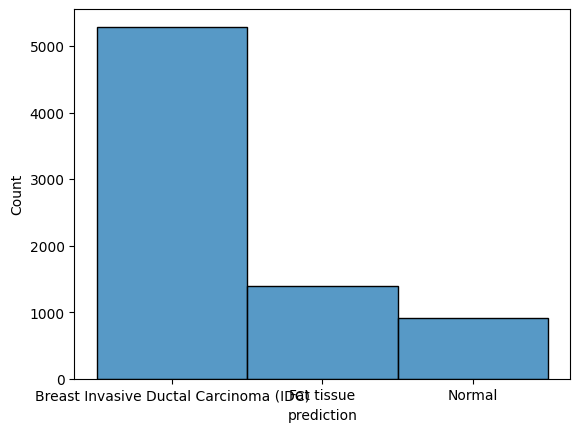

In [237]:
sns.histplot(df_res['prediction'], bins=50)

In [238]:
df_res.top_prompt.value_counts()

top_prompt
breast invasive ductal carcinoma, H&E stain                                           3294
invasive ductal carcinoma, H&E                                                         825
fat in breast tissue, H&E stain                                                        593
a histopathological photograph of invasive carcinoma of the breast, ductal pattern     294
a histopathological image of breast stroma                                             274
                                                                                      ... 
a histopathological image of fat in breast stroma                                        1
a histopathological image of normal breast stroma                                        1
normal breast stroma, H&E stain                                                          1
fat in breast parenchyma is present                                                      1
a histopathological photograph of non-cancerous tissue                         

In [239]:
# is there any prompt in prompt_all that is not in top_prompt
missing_prompts = set(prompts_all) - set(df_res.top_prompt.unique())
missing_prompts


{'a histopathological image of adipose',
 'a histopathological image of adipose tissue',
 'a histopathological image of adipose tissue in breast',
 'a histopathological image of breast IDC',
 'a histopathological image of breast adipose tissue',
 'a histopathological image of breast fat',
 'a histopathological image of breast fat parenchyma',
 'a histopathological image of breast fat tissue',
 'a histopathological image of breast parenchyma',
 'a histopathological image of fat',
 'a histopathological image of fat in breast',
 'a histopathological image of fat in breast parenchyma',
 'a histopathological image of fat in breast tissue',
 'a histopathological image of invasive ductal carcinoma',
 'a histopathological image of non-tumor',
 'a histopathological image of normal breast tissue',
 'a histopathological photograph of adipose',
 'a histopathological photograph of adipose tissue',
 'a histopathological photograph of adipose tissue in breast',
 'a histopathological photograph of bre

In [240]:
row = df_res.iloc[0]

len(row.sim_score)
len(row.prompt_list)

208

['invasive ductal carcinoma, H&E',
 'a histopathological image of breast stroma',
 'invasive ductal carcinoma, H&E',
 'breast invasive ductal carcinoma, H&E stain',
 'a histopathological image of breast stroma',
 'breast invasive ductal carcinoma, H&E stain',
 'breast invasive ductal carcinoma, H&E stain',
 'invasive ductal carcinoma, H&E',
 'fat in breast parenchyma is present',
 'fat in breast stroma, H&E stain']

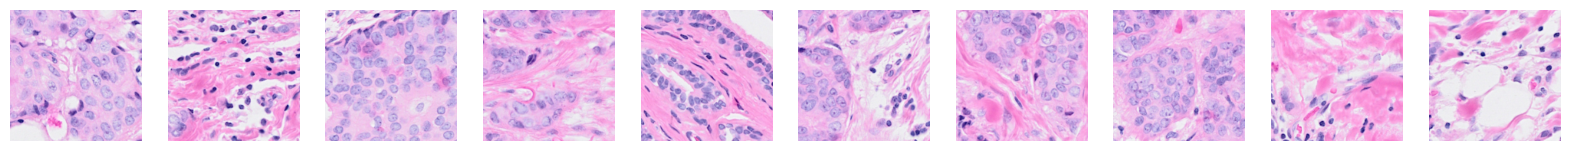

In [241]:
# Plot top prediction patches

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(20, 20))
df_sub = df_res.sample(10)
idx = df_sub.patch_idx.values.tolist()

axes = ax.flatten()
for idx, ax in zip(idx, axes):
    image = Image.fromarray(patches_np[idx])
    image = image.resize((224, 224))
    ax.imshow(image)
    ax.axis('off')

df_sub.top_prompt.values.tolist()


['breast invasive ductal carcinoma, H&E stain',
 'breast invasive ductal carcinoma, H&E stain',
 'invasive ductal carcinoma, H&E',
 'breast invasive ductal carcinoma, H&E stain',
 'breast invasive ductal carcinoma, H&E stain',
 'a histopathological photograph of invasive carcinoma of the breast, ductal pattern',
 'breast invasive ductal carcinoma, H&E stain',
 'invasive ductal carcinoma, H&E',
 'breast invasive ductal carcinoma, H&E stain',
 'breast invasive ductal carcinoma, H&E stain']

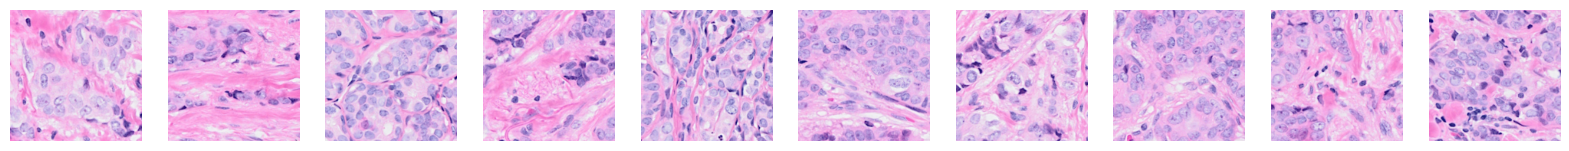

In [242]:
# Plot top prediction patches

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(20, 20))
df_sub = df_res[df_res.prediction == classes[0]].sample(10)
idx = df_sub.patch_idx.values.tolist()

axes = ax.flatten()
for idx, ax in zip(idx, axes):
    image = Image.fromarray(patches_np[idx])
    image = image.resize((224, 224))
    ax.imshow(image)
    ax.axis('off')

df_sub.top_prompt.values.tolist()


In [243]:
# save predictions to npz
pred_enum = {v: k for k, v in enumerate(classes)}
predictions = [pred_enum[p] for p in df_res['prediction'].values.tolist()]
np.savez(f'{case}_predictions.npz', predictions=predictions, barcodes=np.asarray(list(df_res.barcode)))

/mnt/c/src/CONCH/.venv/lib/python3.10/site-packages/numpy/lib/format.py:383: UserWarning: metadata on a dtype is not saved to an npy/npz. Use another format (such as pickle) to store it.
  d['descr'] = dtype_to_descr(array.dtype)
